# <span style="color:blue"> Study of the Coulomb part </span>

In [16]:
include("coulomb.jl")

plot_error (generic function with 2 methods)

## <span style="color:blue"> Source is deg 2 </span>

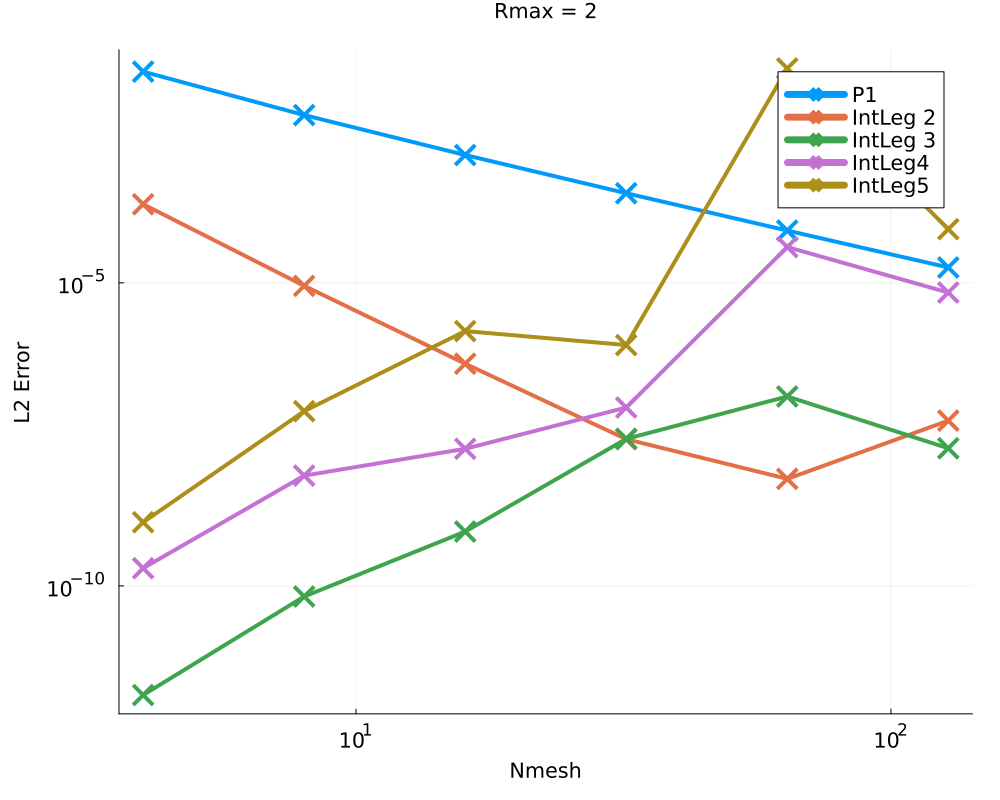

In [6]:
T = Float64
Rmin = 1
Rmax = 2
f = -Polynomial([T(Rmin)*T(Rmax), -T(Rmin) - T(Rmax), T(1)], 0)
plt_error = plot_error(2 .^(2:7), f, Rmin, Rmax)

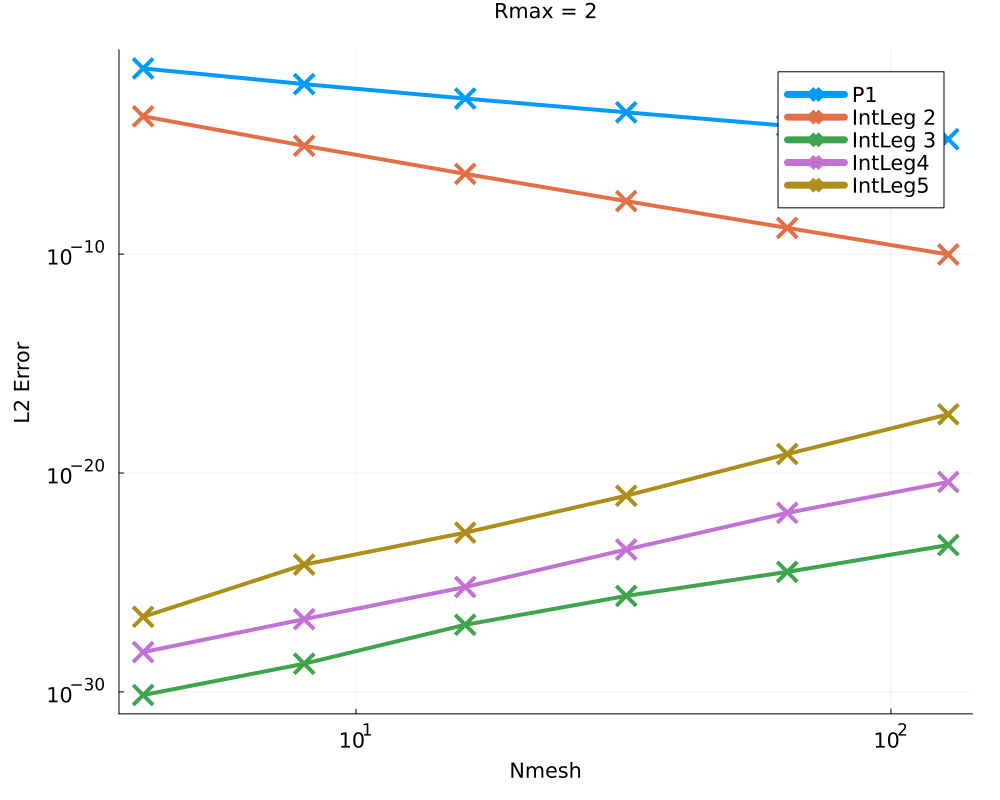

In [12]:
using Quadmath
T = Float128
Rmin = 1
Rmax = 2
f = -Polynomial([T(Rmin*Rmax), -T(Rmin) - T(Rmax), T(1)], 0) 
plt_error = plot_error(2 .^(2:7), f, Rmin, Rmax, T)

## <span style="color:blue"> Source is deg 5 </span>

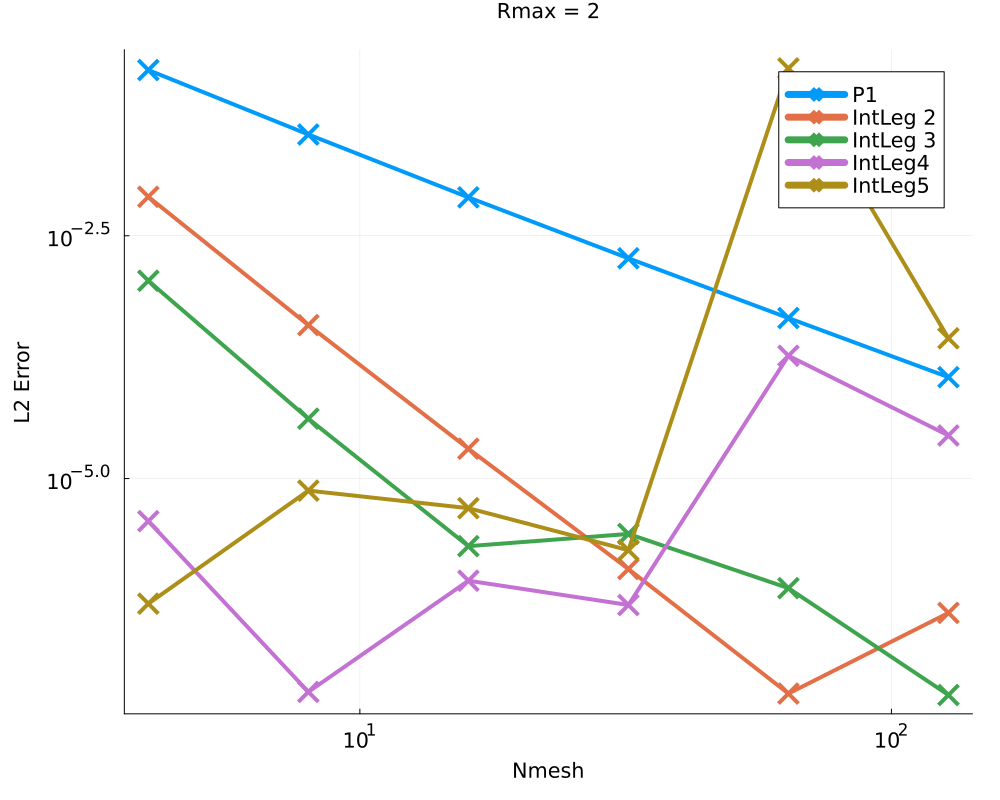

In [20]:
T = Float64
Rmin = 1
Rmax = 2
f = -Polynomial([T(Rmin)*T(Rmax), -T(Rmin) - T(Rmax), T(1)], 0) * RandPolynomial(3)
plt_error = plot_error(2 .^(2:7), f, Rmin, Rmax)

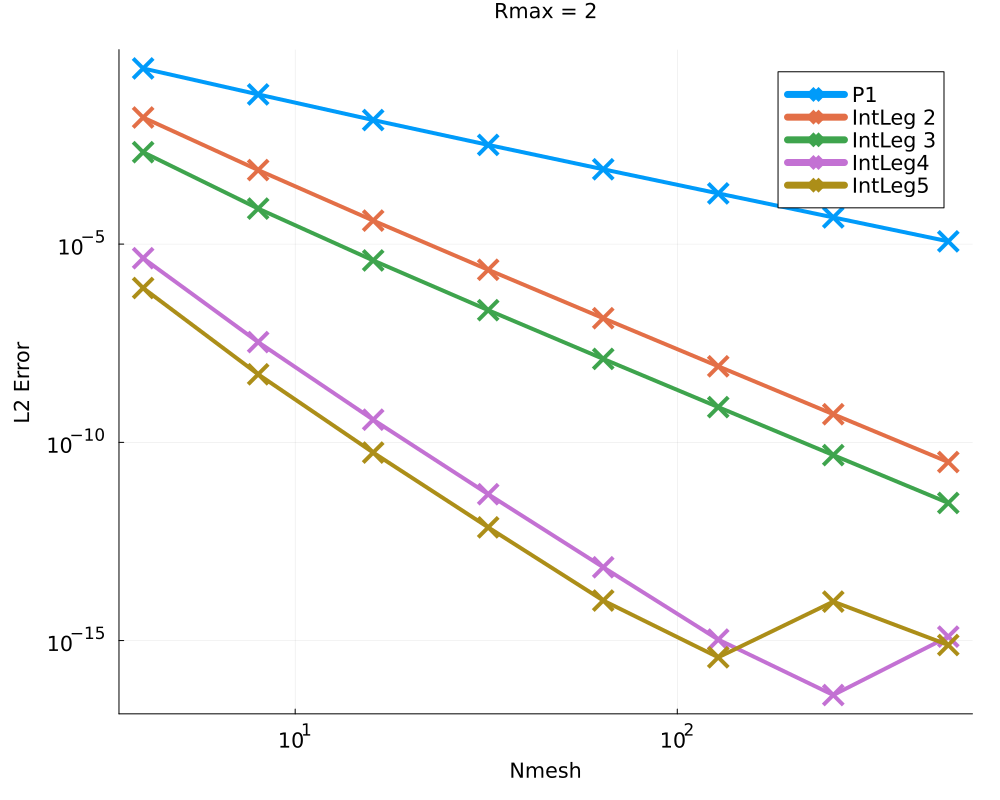

In [18]:
using Quadmath
T = Float128
Rmin = 1
Rmax = 2
f = -Polynomial([T(Rmin*Rmax), -T(Rmin) - T(Rmax), T(1)], 0) * RandPolynomial(T, 3)
plt_error = plot_error(2 .^(2:7), f, Rmin, Rmax, T)

## <span style="color:blue"> Conditionnement de la matrice de Coulomb et analyse d'une source potentiel d'erreur </span>

In [23]:
T = Float64
Rmin = 1
Rmax = 2
Nmesh = 32
mesh = linmesh(Rmin, Rmax, Nmesh)
ordermax = 5
basis = ShortP1IntLegendreBasis(mesh, T; ordermin = 2, ordermax = ordermax,  normalize = true, left = false, right = false)
CIL   = weight_mass_matrix(basis, -1)
cond(CIL)


4.433020967223631e9

In [24]:
using Quadmath
A = randn(Float128,10,10)
A = A + A'
inv(A)

10×10 Matrix{Float128}:
 -3.00994611564777005782660814855433219e-01  …   2.20668378284366186373541919686572473e-01
 -2.05986034854814890414661704560618074e-01      1.41820408798030837206807687621338764e-01
  3.52986917892050384116710950946788384e-01     -5.97321710237829211464713900202897148e-01
 -7.70763578936227823693945632015710380e-03     -2.20687680000847040284825750051032695e-01
  1.52774782175603789855945282796287615e-01     -3.18164319463208307687536647833901672e-01
 -1.34452714270358172477883509425389493e-01  …   3.35343469824925772638596426615478776e-01
  1.93351449378306752508370026929022268e-01     -5.96230459579650730934464528763426796e-01
 -7.25178244452003763703858090062467739e-02      3.31418564006782774539244126839142741e-01
  2.75489975261206557994984470280697332e-01     -7.91259116016810075556293629232268731e-02
  2.20668378284366186373541919686572593e-01     -7.86154828475941586797020240572278030e-01

In [95]:
f = -Polynomial([Rmin*Rmax, -Rmin - Rmax, 1], 0)
F = [integrate(f * build_basis(basis, i), Rmin, Rmax) for i ∈ eachindex(basis)]

296-element Vector{Float64}:
  0.0012286961399468055
  0.0024343673096609564
  0.00361492032982369
  0.004770355200889753
  0.005900671922290712
  0.007005870494595001
  0.008085950917347873
  0.0091409131907767
  0.010170757314881484
  0.011175483289662225
  ⋮
  0.00022125244140625
 -0.0031284396536648273
  0.0002224445343017578
 -0.002257869578897953
  0.0002338886260986328
 -0.001368578290566802
  0.0002384185791015625
 -0.00046056113205850124
  0.0002467632293701172

In [96]:
length(basis)

296

In [97]:
(ib, iib) = KohnShamResolution.find_basis(basis, length(basis))
spb = KohnShamResolution.getbasis(basis, ib)
Pelement = KohnShamResolution.getnormalization(spb,iib) * getpolynomial(spb.elements, spb.infos[iib].index[1])
ϕtrue = (spb.infos[iib].ϕ)[1]
Q = Pelement ∘ ϕtrue
Q = PiecewiseLaurentPolynomial(spb.mesh, [Q], KohnShamResolution.getsegments(spb, iib), T(0))

function Qfun(x)
    i = KohnShamResolution.getsegments(spb, iib)[1]
    if x ≤ mesh[i+1] && x ≥ mesh[i]
        y = ϕtrue(x)
        return Pelement(y)
    else
        return 0
    end
end

Qfun (generic function with 1 method)

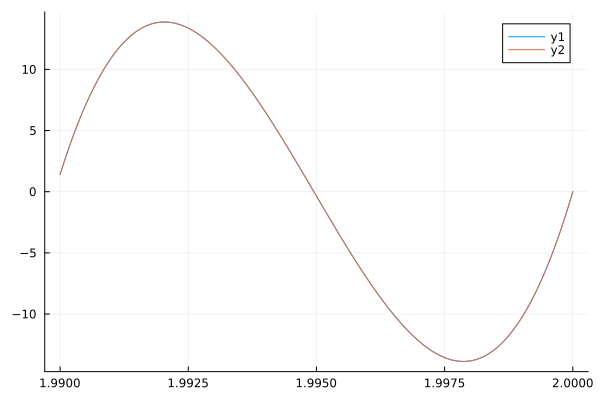

In [99]:
P = build_basis(basis, length(basis))

X = range(1.99, Rmax, 1000)
plot(X, P.(X))
plot!(X,Qfun.(X))

In [100]:
norm(Qfun.(X) .- P.(X))

3.4108318445019295e-5

In [101]:
using Integrals

function compute_second_membre(f, basis)
    T = KohnShamResolution.bottom_type(basis)
    b = zeros(T, length(basis))
    for i ∈ eachindex(basis)
        (ib, iib) = KohnShamResolution.find_basis(basis, i)
        spb = KohnShamResolution.getbasis(basis, ib)
        val = zero(T)
        for (j,_,_, invϕ) ∈ spb.infos[iib]
            Pelement = KohnShamResolution.getnormalization(spb,iib) * getpolynomial(spb.elements, j)
            g(x) = f(invϕ(x)) * Pelement(x)
            prob = IntegralProblem((x,p) -> g(x), -1, 1)
            val += invϕ[1] * solve(prob, QuadGKJL(); reltol = 1e-12, abstol = 1e-12).u
        end
        b[i] = val
    end
    b
end

Fbis = compute_second_membre(f, basis)

norm(F .- Fbis)

1.3999692668136657e-5